## Lec 7. 自然语言处理 Nature Language Processing

- 传统NLP
    - 命名实体抽取
    - 词性标注
    - 中文分词 (jieba)
    - 文本挖掘 (关键词提取 TF-IDF)
    - .......
- 现代NLP (神经网络)
    - 文本情感分析 Sentiment Analysis
    - 神经机器翻译 NMT
    - 大语言模型 LLM
    - ......
    
- word2vec (Skip-Gram / CBOW)
    - nn.Embedding (Token -> Vector)
    - nn.Linear (Vector -> Classification -> Token)

### 7.1 文本数据预处理

In [7]:
class Vocab:
    """ 用于存储单词词元的词典类 """
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        
    def add(self, word):
        """ 用于向词典中添加新的单词 """
        if word not in self.idx2word:
            self.word2idx[word] = len(self.idx2word)
            self.idx2word.append(word)
            
    def __len__(self):
        """ 用于返回该词典的长度 """
        return len(self.idx2word)

In [1]:
import pandas as pd

df_reviews = pd.read_csv("./data/Amazon-Product-Reviews - Amazon Product Review.csv")[["review_body", "sentiment"]]
df_reviews = df_reviews.head(100)
df_reviews

,review_body,sentiment
0,Great love it,1
1,Lots of ads<br />Slow processing speed<br />Oc...,0
2,Excellent unit. The versatility of this table...,1
3,I bought this on Amazon Prime so I ended up bu...,1
4,All Amazon products continue to meet my expect...,1
...,...,...
95,Excellent,1
96,Love the upgrade.,1
97,It was a birthday gift and I love it,1
98,My 8 and 7 year old love their tablets!,1


In [3]:
from typing import List

def text_preprocessing(doc: str)->List[str]:
    """ 文本预处理函数 """
    stop_words = ["(", ")", ",", ".", "?", "!", "=", "<", ">", "[", "]", ""]
    doc = doc.replace("<br />", " ")
    return [item.lower() for item in doc.strip().split(" ") if item not in stop_words]

In [9]:
vocab = Vocab()

for idx, row in df_reviews.iterrows(): #.iterrows()每次迭代返回一个 (index, Series) 元组，其中 index是行标签，Series包含行的数据
    for word in text_preprocessing(row.review_body):
        vocab.add(word)

In [11]:
len(vocab)

984

### 7.2 嵌入层 Embedding

In [14]:
# word (tokenize)-> [0, 1, 2] (vectorize)-> array -> tensor -> model -> output
# word2vec: 

In [16]:
import torch
import torch.nn as nn

class Embedding(nn.Module):
    """ 嵌入层 """
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.fc = nn.Linear(vocab_size, embedding_size)
        
    def forward(self, token):
        """ 前向传播方法 """
        # x: 16 -> [vocab_size] -> [embedding_size]
        one_hot = torch.zeros(self.vocab_size)
        one_hot[token] = 1
        return self.fc(one_hot)

In [17]:
model = Embedding(len(vocab), 16)
model(20)

tensor([-0.0136,  0.0499, -0.0258, -0.0012,  0.0275,  0.0150,  0.0040, -0.0165,
         0.0313,  0.0260, -0.0297,  0.0335, -0.0100, -0.0156,  0.0247,  0.0227],
       grad_fn=<ViewBackward0>)

### 7.3 Word2Vec [Skip-Gram] 词向量模型

- target (中心词)
- context (上下文)

In [21]:
class Word2Vec(nn.Module):
    """ 词向量模型 """
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.fc = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, x):
        embedded = self.embeddings(x)  # [batch_size, embedding_size]
        return self.fc(embedded)       # [batch_size, vocab_size]    

In [23]:
model = Word2Vec(len(vocab), 16)
model

Word2Vec(
  (embeddings): Embedding(984, 16)
  (fc): Linear(in_features=16, out_features=984, bias=True)
)

In [25]:
df_reviews.review_body.values[1]

'Lots of ads<br />Slow processing speed<br />Occasionally shuts down apps<br />WIFI keeps having authentication issues<br /><br />Was cheap for a tablet and now i know why.'

In [27]:
def skipgram_data(words: List[str], window_size: int=1):
    """ 创建 Skip-Gram模型训练数据 """
    data = []
    for i, target_word in enumerate(words):
        for j in range(max(0, i-window_size), min(len(words), i+window_size+1)):
            if j != i:
                context_word = words[j]
                data.append((vocab.word2idx.get(target_word), vocab.word2idx.get(context_word)))
    return data
                
# line = text_preprocessing(df_reviews.review_body.values[1])
# skipgram_data(line, 1)

In [29]:
all_words = []
for i in range(len(df_reviews.review_body.values)):
    preprocessed_text = text_preprocessing(df_reviews.review_body.values[i])
    all_words.extend(preprocessed_text)

In [31]:
from torch.utils.data import Dataset, DataLoader

class SkipGramDataset(Dataset):
    """ SkipGram 模型数据集 """
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        target = self.data[idx][0]
        context = self.data[idx][1]
        return torch.tensor(target, dtype=torch.long), torch.tensor(context, dtype=torch.long) #dtype=torch.long表示创建的是长整型
    
# data = skipgram_data(line, 1)
data = skipgram_data(all_words, 1)
dataset = SkipGramDataset(data)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [33]:
next(iter(dataloader))

[tensor([305, 823,  18, 571]), tensor([627, 282, 787, 549])]

In [35]:
def train_model(model, dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    model.train()
    total_loss = 0.
    for target, context in dataloader:
        context_hat = model(target)
        loss = loss_func(context_hat, context)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [37]:
model = Word2Vec(len(vocab), 16)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [41]:
n_epoch = 500
train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {round(loss, 4)}")

Epoch 1 loss: 5.3472
Epoch 2 loss: 5.2175
Epoch 3 loss: 5.104
Epoch 4 loss: 5.0019
Epoch 5 loss: 4.9097
Epoch 6 loss: 4.8249
Epoch 7 loss: 4.7448
Epoch 8 loss: 4.6714
Epoch 9 loss: 4.6005
Epoch 10 loss: 4.5349
Epoch 11 loss: 4.4714
Epoch 12 loss: 4.4115
Epoch 13 loss: 4.3551
Epoch 14 loss: 4.3006
Epoch 15 loss: 4.2494
Epoch 16 loss: 4.1987
Epoch 17 loss: 4.1529
Epoch 18 loss: 4.1059
Epoch 19 loss: 4.0631
Epoch 20 loss: 4.0218
Epoch 21 loss: 3.9823
Epoch 22 loss: 3.9435
Epoch 23 loss: 3.9065
Epoch 24 loss: 3.8724
Epoch 25 loss: 3.8399
Epoch 26 loss: 3.8079
Epoch 27 loss: 3.7768
Epoch 28 loss: 3.7469
Epoch 29 loss: 3.7185
Epoch 30 loss: 3.6919
Epoch 31 loss: 3.6657
Epoch 32 loss: 3.6407
Epoch 33 loss: 3.6169
Epoch 34 loss: 3.5954
Epoch 35 loss: 3.5734
Epoch 36 loss: 3.5518
Epoch 37 loss: 3.533
Epoch 38 loss: 3.5139
Epoch 39 loss: 3.4951
Epoch 40 loss: 3.4769
Epoch 41 loss: 3.4615
Epoch 42 loss: 3.4461
Epoch 43 loss: 3.429
Epoch 44 loss: 3.4153
Epoch 45 loss: 3.4017
Epoch 46 loss: 3.3873


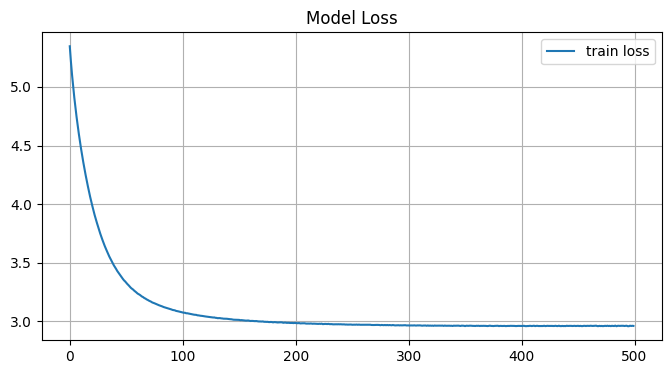

In [47]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(8, 4))
plt.plot(train_loss, label="train loss")
plt.title("Model Loss")
plt.grid()
plt.legend()
plt.show()